# Plotting

This notebook is running Julia 0.4 so I can actually plot things.

## Getting data

In [200]:
using DataStructures
# using DataFrames
using Gadfly
set_default_plot_size(22cm, 15cm)

In [10]:
base_counts = deserialize(open("data/base_counts.jld"))
eco_counts = deserialize(open("data/eco_counts.jld"))

DataStructures.DefaultDict{Symbol,Int64,Int64} with 86 entries:
  :if                 => 53780
  :$=                 => 80
  :.'                 => 167
  :\=                 => 2
  :&=                 => 78
  :export             => 24571
  :type               => 8961
  :tuple              => 110757
  :./=                => 61
  :string             => 11924
  :dict_comprehension => 130
  :(=)                => 383353
  :for                => 27339
  :kw                 => 49616
  :cell1d             => 557
  :(:=)               => 11
  :try                => 1954
  :macrocall          => 133020
  :<<=                => 37
  :...                => 14824
  :ref                => 154337
  :using              => 10809
  :.^=                => 2
  :'                  => 3384
  :return             => 28748
  ⋮                   => ⋮

In [239]:
function to_df(d::Associative)
    df = DataFrame()
    ks = []
    vs = []
    for (k,v) in d
        push!(ks, k)
        push!(vs, v)
    end
    df[:h] = map(string, ks)
    df[:head] = map(x->Markdown.htmlesc(string(x)), ks)
    df[:count] = vs
    df
end

to_df (generic function with 1 method)

In [242]:
bdf = to_df(base_counts)
edf = to_df(eco_counts)
rename!(bdf, :count, :b_count)
rename!(edf, :count, :e_count)
df = join(edf, bdf, on=[:head, :h], kind=:left)
df[df[:b_count].na, :b_count] = 0 # Set NA values to 0s

0

In [216]:
setdiff(keys(eco_counts), keys(base_counts))

11-element Array{Symbol,1}:
 :\=            
 :cell1d        
 :(:=)          
 :.^=           
 :-->           
 :.-=           
 :stagedfunction
 :incomplete    
 :cell2d        
 :typed_dict    
 :dict          

In [128]:
df[:b_count].na

86-element BitArray{1}:
 false
 false
 false
 false
 false
 false
 false
 false
 false
 false
 false
 false
 false
     ⋮
 false
 false
 false
 false
 false
 false
 false
 false
 false
 false
 false
 false

## Plot of expression counts

* I want to see a relative count of each 

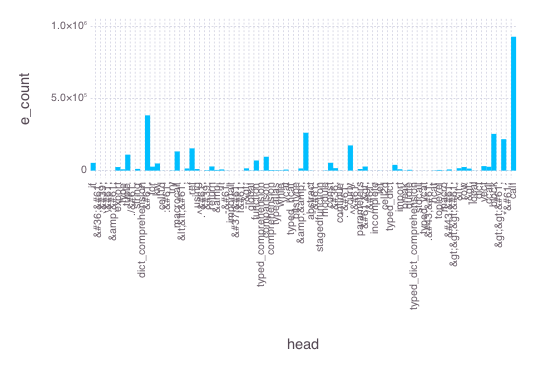

In [87]:
plot(edf, x="head", y="e_count", Geom.bar(position=:dodge))

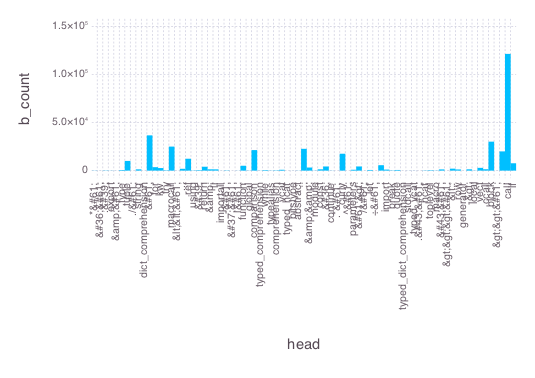

In [88]:
plot(bdf, x="head", y="b_count", Geom.bar(position=:dodge))

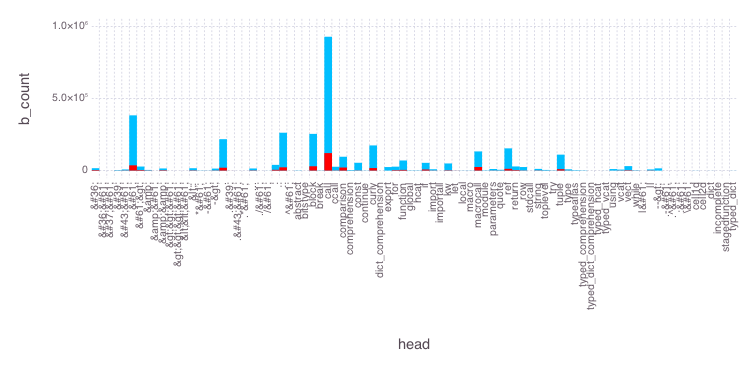

In [183]:
plot(df, 
layer(x="head", y="b_count", Theme(default_color=color("red")), Geom.bar(position=:dodge)),
layer(x="head", y="e_count", Geom.bar(position=:dodge)))

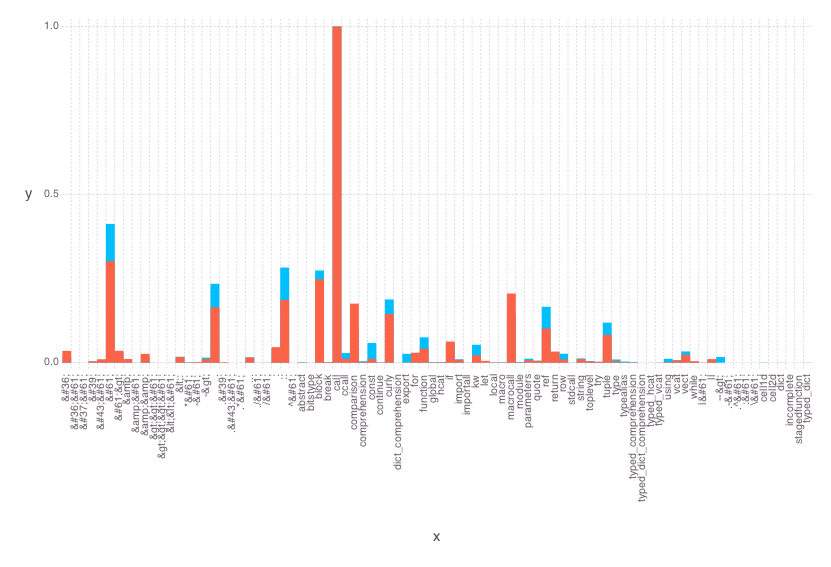

In [201]:
plot(#df, 
layer(x=df[:head], 
      y=df[:b_count]./maximum(df[:b_count]), 
      Theme(default_color=color("tomato"), panel_opacity=0.5), 
      Geom.bar(position=:stack)
),
layer(x=df[:head], 
      y=df[:e_count]./maximum(df[:e_count]), 
      Geom.bar(position=:stack)
))

In [179]:
df2 = stack(df, [:b_count, :e_count])

,variable,value,head
1,b_count,4289,&#36;
2,b_count,25,&#36;&#61;
3,b_count,4,&#37;&#61;
4,b_count,532,&#39;
5,b_count,1241,&#43;&#61;
6,b_count,36676,&#61;
7,b_count,4305,&#61;&gt;
8,b_count,1330,&amp;
9,b_count,41,&amp;&#61;
10,b_count,3194,&amp;&amp;


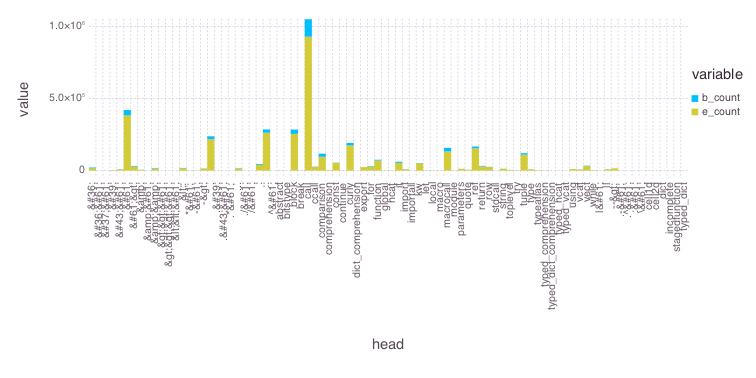

In [188]:
plot(df2,
x="head",
y="value",
color="variable",
Geom.bar())

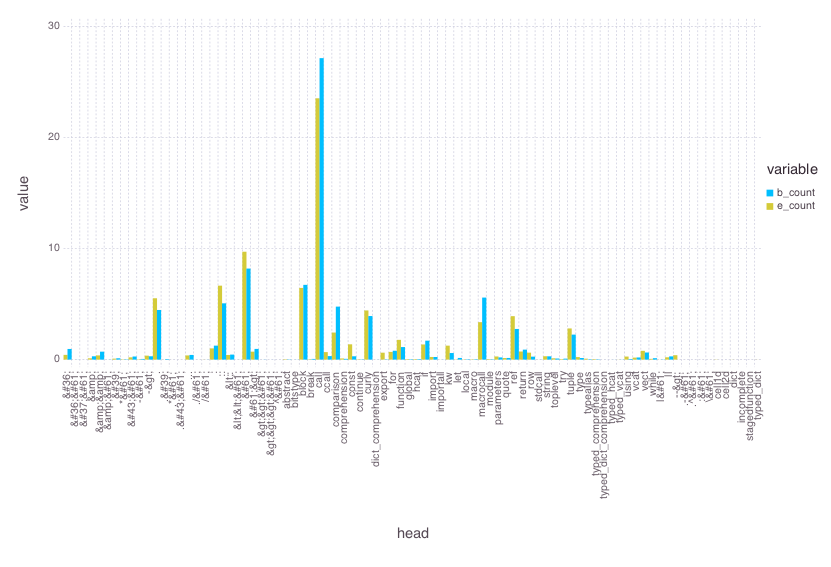

In [244]:
begin
    df3 = copy(df)
    df3[:b_count] = df3[:b_count]./mean(df3[:b_count]) #
    df3[:e_count] = df3[:e_count]./mean(df3[:e_count])
    df3_stacked = stack(df3, [:b_count, :e_count])
    
    plot(df3_stacked,
        x="head",
        y="value",
        color="variable",
        Geom.bar(position=:dodge)
    )
#     plot(df3,
#     x=df3[:head]
    #     y=df3[:])
end


In [218]:
df2

,variable,value,head
1,b_count,4289,&#36;
2,b_count,25,&#36;&#61;
3,b_count,4,&#37;&#61;
4,b_count,532,&#39;
5,b_count,1241,&#43;&#61;
6,b_count,36676,&#61;
7,b_count,4305,&#61;&gt;
8,b_count,1330,&amp;
9,b_count,41,&amp;&#61;
10,b_count,3194,&amp;&amp;
